<h3 style="margin-bottom: 1em;"><img src="https://www.proteinmetrics.com/wp-content/uploads/2017/08/logo.svg" width="320" style="display: inline; margin: 0 2em 0 0;" /> Peak Isotopes Deltas</h3>

In [1]:
import os
import re
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.stats
from pyteomics import mzml
from IPython.display import HTML, Markdown, display_html
from scipy.optimize import curve_fit

In [2]:
# global settings and variables
pd.set_option('display.float_format', lambda x: '%.4f' % x)
connections = {}

In [3]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)



def fetch_peaks_from_byspec2(byspec2_path, offset=0, limit=1000):
    global connections
    if byspec2_path not in connections:
        connections[byspec2_path] = sqlite3.connect(byspec2_path)
        
    conn   = connections[byspec2_path]
    query  = "SELECT s.Id, s.RetentionTime, s.ScanNumber, s.NativeId, p.PeaksMz, p.PeaksIntensity " + \
             "FROM Spectra AS s JOIN Peaks AS p ON (s.PeaksId = p.Id)" + \
             "WHERE (s.MSLevel = 1) AND (p.PeaksCount > 0) " + \
             "LIMIT {},{}".format(offset, limit)
    return conn.execute(query).fetchall()

In [4]:
def get_scans(byspec2_path, offset, limit):
    result = fetch_peaks_from_byspec2(byspec2_path, offset, limit)
    return [
        {
            'id':       row[0],
            'rt':       row[1],
            'number':   row[2],
            'nativeId': row[3],
            'mz':       np.frombuffer(row[4], dtype=np.float64),
            'intens':   np.frombuffer(row[5], dtype=np.float32)
        }
        for row in result
    ]

--- 
### Peak-Delta Metric

In [5]:
full_centroid_mode_byspec2_filename = './prg.centroid_const_01_fullgauss.byspec2'
middle_sigma_centroid_mode_byspec2_filename = './prg.centroid_const_005_middles.byspec2'
#middle_sigma_centroid_mode_byspec2_filename = './prg.centroid_const_01_fullgauss_wopico.byspec2'

#if 'BYSPEC2_FILE' in os.environ:
#    display('WARNING: using BYSPEC2_FILE set through env var:', os.environ['BYSPEC2_FILE'])
#    centroid_mode_byspec2_filename = os.environ['BYSPEC2_FILE']

In [6]:
offset = int(os.environ.get('BYSPEC2_OFFSET', '2000'))
limit  = int(os.environ.get('BYSPEC2_LIMIT',  '1000'))
full_scans  = get_scans(full_centroid_mode_byspec2_filename, offset, limit)
mids_scans  = get_scans(middle_sigma_centroid_mode_byspec2_filename, offset, limit)
#display('Sample full gaussian scan:', full_scans[len(full_scans) // 2])
display('Sample full gaussian scan:', full_scans[len(full_scans) // 2]['id'])
#display('Sample middle sigma scan:', mids_scans[len(mids_scans) // 2])
display('Sample middle sigma scan:', mids_scans[len(mids_scans) // 2]['id'])

'Sample full gaussian scan:'

14731

'Sample middle sigma scan:'

14731

#### Check spectra - Full Gaussian Scan #13002

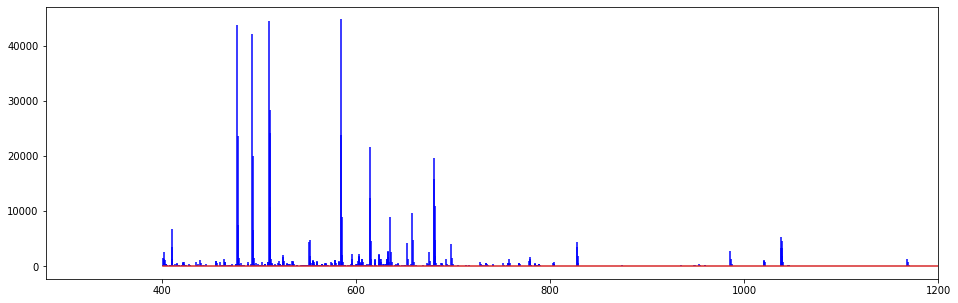

In [7]:
# visually check the dataset by plotting the profile-mode spectra
fig, ax = plt.subplots(1, 1, figsize=(16,5))
fscan = full_scans[len(full_scans) // 3]
ax.stem(fscan['mz'], fscan['intens'], use_line_collection=True, linefmt='b-', markerfmt=' ');
ax.set_xlim(280, 1200)
display(Markdown('#### Check spectra - Full Gaussian Scan #{}'.format(fscan['id'])))

In [8]:
POINTS_TO_CHECK=8
C13_MASS_DIFF=1.003355
NDIFFS=[C13_MASS_DIFF/5, C13_MASS_DIFF/4, C13_MASS_DIFF/3, C13_MASS_DIFF/2, 2*C13_MASS_DIFF/3, C13_MASS_DIFF]
#, 2*C13_MASS_DIFF]
DIFF_ERR = C13_MASS_DIFF * 0.02

def find_near_points(scan, point, diff):
    mz_val = scan[point]
    ret_fpoint = -1
    points_to_check = 2 + int(POINTS_TO_CHECK * diff)
    if point + 1 < scan.size:
        last_point = min(point+points_to_check, scan.size)

        next_scan = scan[point+1:last_point] - (mz_val + diff)
        next_scan[next_scan > DIFF_ERR] = np.inf
        next_scan[next_scan < -DIFF_ERR] = np.inf

        next_mz = np.absolute(next_scan).argmin()
        if next_scan[next_mz] != np.inf:
            ret_fpoint = point + next_mz + 1

    return ret_fpoint

def build_diff_dataframe(scans):
    def _mzdiff(mz, distance):
        diff = np.full(mz.size, np.NaN, dtype=mz.dtype)
        for i_mz in range(mz.size):
            next_mz = find_near_points(mz, i_mz, distance)
            if next_mz >=0:
                #display('distance: {} prev:{} i_mz:{} next:{} values:({}, {}, {})'.format(
                #    distance, prev_mz, i_mz, next_mz, mz[prev_mz], mz[i_mz], mz[next_mz])) 
                diff[i_mz] = mz[next_mz] - mz[i_mz]
                #diff[i_mz] = mz[next_mz] - mz[i_mz]
                #display(diff[i_mz])
        diff = np.resize(diff, mz.shape)
        return diff 

    def _diff_rowdata(scan):
        return np.stack(
            [np.full(scan['mz'].size, scan['id'], dtype=np.int32), scan['mz']] +
            [_mzdiff(scan['mz'], ndiff) for ndiff in NDIFFS],
            axis=1
        )

    data = np.concatenate([
        _diff_rowdata(scan)
        for scan in scans
        if scan['mz'].size >= 3*POINTS_TO_CHECK
    ], axis=0)
    columns = np.array(['scan id', 'mz'] + ['diff{:.2f}'.format(ndiff) for ndiff in NDIFFS])

    df = pd.DataFrame(columns=columns, data=data)
    df['scan id'] = df['scan id'].astype('int32')
    return df

from numpy.random import seed
from numpy.random import rand
seed(1)

t_mz = np.arange(200, 300, 0.2)
noise = rand(t_mz.size) -0.5
t_mz += noise
scan1 = {'id':1, 'mz': np.sort(t_mz)}

seed(2)
t_mz2 = np.arange(200, 300, 0.3)
noise = rand(t_mz2.size) -0.5
t_mz2 += noise
scan2 = {'id':2, 'mz': np.sort(t_mz2)}
test_scans = [scan1, scan2]

test_df = build_diff_dataframe(test_scans)
display('Test data')

display(test_df.describe())


'Test data'

scan id       mz  diff0.20  diff0.25  diff0.33  diff0.50  diff0.67  \
count 834.0000 834.0000   99.0000  111.0000  107.0000  148.0000  137.0000   
mean    1.4005 249.9181    0.2006    0.2519    0.3325    0.4995    0.6681   
std     0.4903  28.9222    0.0117    0.0117    0.0115    0.0104    0.0117   
min     1.0000 199.8259    0.1809    0.2312    0.3147    0.4821    0.6495   
25%     1.0000 225.0691    0.1919    0.2407    0.3221    0.4905    0.6584   
50%     1.0000 249.8804    0.2008    0.2514    0.3308    0.4989    0.6667   
75%     2.0000 274.8613    0.2092    0.2622    0.3422    0.5068    0.6774   
max     2.0000 300.0202    0.2207    0.2708    0.3537    0.5217    0.6889   

       diff1.00  
count  123.0000  
mean     1.0023  
std      0.0109  
min      0.9834  
25%      0.9936  
50%      1.0028  
75%      1.0119  
max      1.0230

In [9]:
fdf = build_diff_dataframe(full_scans)
mdf = build_diff_dataframe(mids_scans)
display('Full Gaussian / Middle Sigma Gaussian centroiding')

display_side_by_side(fdf.describe(), mdf.describe())
#display(fdf.describe())
# display(mdf.describe())

#display_side_by_side(fdf.sample(4), mdf.sample(4))
#display(fdf.sample(4))
#display(mdf.sample(4))

'Full Gaussian / Middle Sigma Gaussian centroiding'

scan id 
 mz 
 diff0.20 
 diff0.25 
 diff0.33 
 diff0.50 
 diff0.67 
 diff1.00 
 
 
 
 
 count 
 999895.0000 
 999895.0000 
 67062.0000 
 139370.0000 
 249074.0000 
 277834.0000 
 201617.0000 
 372925.0000 
 
 
 mean 
 14596.8657 
 627.7971 
 0.1998 
 0.2511 
 0.3342 
 0.5013 
 0.6686 
 1.0028 
 
 
 std 
 2722.3182 
 149.3391 
 0.0102 
 0.0084 
 0.0076 
 0.0080 
 0.0087 
 0.0089 
 
 
 min 
 9731.0000 
 400.0173 
 0.1806 
 0.2308 
 0.3144 
 0.4816 
 0.6488 
 0.9833 
 
 
 25% 
 12182.0000 
 515.2862 
 0.1921 
 0.2465 
 0.3303 
 0.4970 
 0.6635 
 0.9972 
 
 
 50% 
 14720.0000 
 606.3203 
 0.2000 
 0.2508 
 0.3342 
 0.5013 
 0.6684 
 1.0026 
 
 
 75% 
 17234.0000 
 706.3396 
 0.2070 
 0.2556 
 0.3380 
 0.5055 
 0.6736 
 1.0081 
 
 
 max 
 18844.0000 
 1249.9480 
 0.2207 
 0.2709 
 0.3545 
 0.5217 
 0.6890 
 1.0234 
 
 
 
 
 
 
 scan id 
 mz 
 diff0.20 
 diff0.25 
 diff0.33 
 diff0.50 
 diff0.67 
 diff1.00 
 
 
 
 
 count 
 907574.0000 
 907574.0000 
 44752.0000 
 106344.0000 
 192470.0000 
 222721.0000 
 147426.0000 
 300455.0000 
 
 
 mean 
 14578.6777 
 626.1401 
 0.2017 
 0.2506 
 0.3336 
 0.5009 
 0.6682 
 1.0026 
 
 
 std 
 2728.4854 
 148.9690 
 0.0104 
 0.0081 
 0.0073 
 0.0076 
 0.0082 
 0.0086 
 
 
 min 
 9731.0000 
 400.0371 
 0.1806 
 0.2308 
 0.3144 
 0.4816 
 0.6488 
 0.9833 
 
 
 25% 
 12145.0000 
 516.2726 
 0.1945 
 0.2464 
 0.3302 
 0.4971 
 0.6637 
 0.9975 
 
 
 50% 
 14712.0000 
 602.5502 
 0.2013 
 0.2506 
 0.3339 
 0.5011 
 0.6681 
 1.0025 
 
 
 75% 
 17246.0000 
 699.3655 
 0.2098 
 0.2546 
 0.3372 
 0.5047 
 0.6725 
 1.0075 
 
 
 max 
 18844.0000 
 1249.6035 
 0.2207 
 0.2709 
 0.3545 
 0.5217 
 0.6890 
 1.0234

In [10]:
EXPECTED_MZ_DIFFS = np.array(NDIFFS)
def plot_mzdiff_hist(series, nbins=25, logscale=False, ax=None, title=None):
    ax   = series.hist(bins=nbins, ax=ax, figsize=(None if ax else (16, 4)))
    # ymax = ax.get_ylim()[1]
    #ax.stem(EXPECTED_MZ_DIFFS, np.full(EXPECTED_MZ_DIFFS.size, ymax),
    #        use_line_collection=True, linefmt='b-', markerfmt=' ');
    # ax.set_xlim(-.2, 1.2)
    #ax.set_xlim(series.min, series.max)
    
    ax.set_title(title)
    if logscale:
        plt.yscale('log', nonposy='clip');

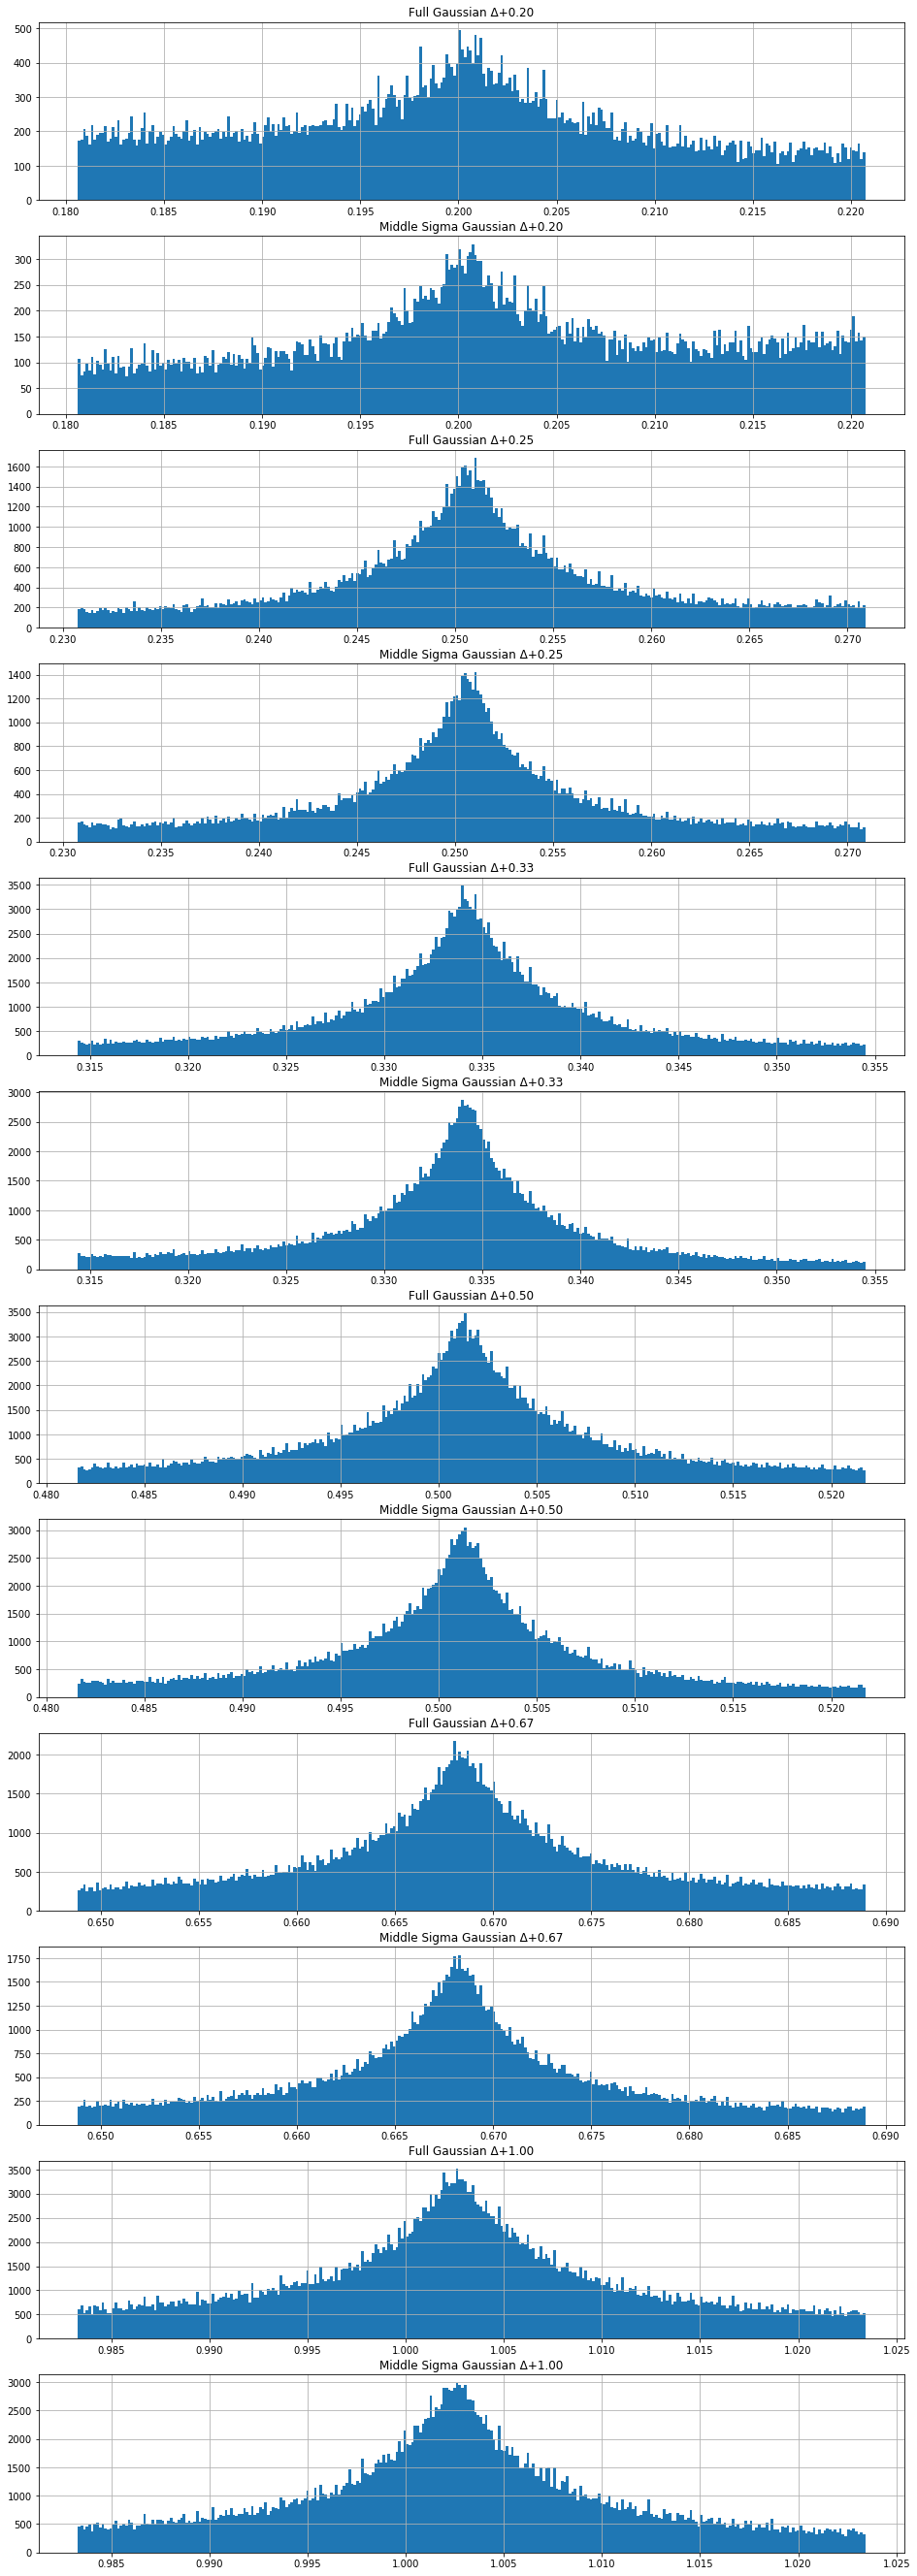

In [11]:
fdiff_cols = [col for col in fdf.columns if col.startswith('diff')]
mdiff_cols = [col for col in mdf.columns if col.startswith('diff')]

fig, axes = plt.subplots(len(fdiff_cols) + len(mdiff_cols), 1, figsize=(16, 4 * (len(fdiff_cols) + len(mdiff_cols)))) 
axes = list(axes)

for fcol, mcol in zip(fdiff_cols, mdiff_cols):
    plot_mzdiff_hist(fdf[fcol], nbins=300, logscale=False, ax=axes.pop(0),
                     title='Full Gaussian Δ+{}'.format(fcol[-4:]))
    plot_mzdiff_hist(mdf[mcol], nbins=300, logscale=False, ax=axes.pop(0),
                     title='Middle Sigma Gaussian Δ+{}'.format(mcol[-4:]))                                                                            
                                                                                 

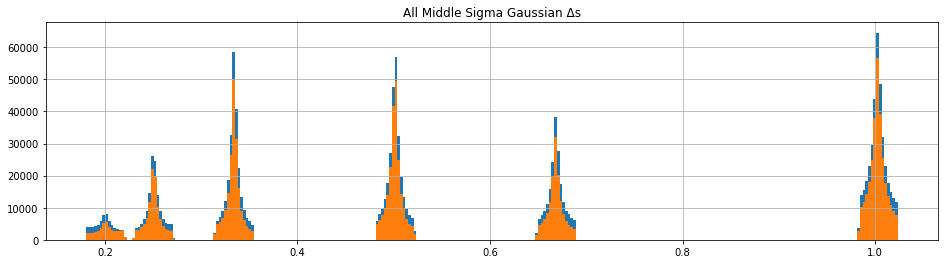

In [12]:
alldiff_fdf = pd.DataFrame(
    data=np.concatenate([fdf[col] for col in fdf.columns if col.startswith('diff')]),
    columns=['diff']
)
plot_mzdiff_hist(alldiff_fdf['diff'], nbins=300, title='All Full Gaussian Δs')

alldiff_mdf = pd.DataFrame(
    data=np.concatenate([mdf[col] for col in mdf.columns if col.startswith('diff')]),
    columns=['diff']
)
plot_mzdiff_hist(alldiff_mdf['diff'], nbins=300, title='All Middle Sigma Gaussian Δs')

In [13]:
def display_mzdiff_stats(fseries, mseries, ftitle, mtitle, in_range_percentage=10.0):
    def _points_in_range(series, ref_value):
        abs_range = (ref_value * in_range_percentage / 100.0)
        return series[abs(series - ref_value) < abs_range]
    
    def _stats(series, expected_diff):
        nearby_points = _points_in_range(series, expected_diff)
        return [
            expected_diff, nearby_points.count(), nearby_points.mean(), nearby_points.std(),
            scipy.stats.variation(nearby_points.values, nan_policy='omit')
        ]
    
    fdata = [ _stats(fseries, expected_diff) for expected_diff in EXPECTED_MZ_DIFFS ]
    mdata = [ _stats(mseries, expected_diff) for expected_diff in EXPECTED_MZ_DIFFS ]
    fstatsdf = pd.DataFrame(columns=['expected m/z diff', 'count', 'mean', 'stddev', 'variation'], data=fdata)
    mstatsdf = pd.DataFrame(columns=['expected m/z diff', 'count', 'mean', 'stddev', 'variation'], data=mdata)
    
    display(HTML('<h4>{}   ---     {}</h4>'.format(ftitle, mtitle)))
    display_side_by_side(fstatsdf, mstatsdf)
    
    fexpected = 100.0 * fstatsdf['count'].sum() / fseries.size
    mexpected = 100.0 * mstatsdf['count'].sum() / mseries.size    
    display(HTML('<span># points within {}% of expected diffs: </span>: <b>{} - {}  ({:.2f}%) - ({:.2f}%)</b>'.format(
        in_range_percentage, fstatsdf['count'].sum(), mstatsdf['count'].sum(), fexpected, mexpected)))
    

In [14]:

ftitle='Full Gaussian All neighbors (deltas)'
mtitle='Middle Sigma All neighbors (deltas)'

display_mzdiff_stats(alldiff_fdf['diff'], alldiff_mdf['diff'], ftitle, mtitle, 8.0)


expected m/z diff 
 count 
 mean 
 stddev 
 variation 
 
 
 
 
 0 
 0.2007 
 57021 
 0.2001 
 0.0081 
 0.0407 
 
 
 1 
 0.2508 
 139370 
 0.2511 
 0.0084 
 0.0335 
 
 
 2 
 0.3345 
 249074 
 0.3342 
 0.0076 
 0.0227 
 
 
 3 
 0.5017 
 277834 
 0.5013 
 0.0080 
 0.0159 
 
 
 4 
 0.6689 
 201617 
 0.6686 
 0.0087 
 0.0130 
 
 
 5 
 1.0034 
 372925 
 1.0028 
 0.0089 
 0.0089 
 
 
 
 
 
 
 expected m/z diff 
 count 
 mean 
 stddev 
 variation 
 
 
 
 
 0 
 0.2007 
 37568 
 0.2012 
 0.0082 
 0.0407 
 
 
 1 
 0.2508 
 106344 
 0.2506 
 0.0081 
 0.0322 
 
 
 2 
 0.3345 
 192470 
 0.3336 
 0.0073 
 0.0219 
 
 
 3 
 0.5017 
 222721 
 0.5009 
 0.0076 
 0.0152 
 
 
 4 
 0.6689 
 147426 
 0.6682 
 0.0082 
 0.0123 
 
 
 5 
 1.0034 
 300455 
 1.0026 
 0.0086 
 0.0086